# Registration of SHG to Polscope

This script takes the large SHG images, downsamples them to a similar resolution as the polscope ones, then registers onto the polscope image.

It finishes by masking the SHG image using the MMP image - to mimic the restricted field of view on the MMP image


# System setup and functions

In [1]:
import SimpleITK as sitk

import numpy as np
import numpy.ma as ma

import math

from myshow import myshow



import os
import sys
PolDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Polscope_BasicCorrected/"
SHGDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/SHG/"
OutDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Reg Mask Output/"

# setup our plotting environment
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

# Setup our widgets environment
# GUI components (sliders, dropdown...).
from ipywidgets import interact

# Enable display of HTML.
from IPython.display import clear_output


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0]*2
fig_size[1] = fig_size[1]*2
plt.rcParams["figure.figsize"] = fig_size

In [2]:
#Function to resize images
def resizeImage(itkImg, currentRes, targetRes):
    if targetRes > currentRes:
        scale = math.floor(targetRes/currentRes)
        endRes = currentRes*scale
        resampled = sitk.Shrink(itkImg,[scale,scale])
        resampled.SetSpacing([endRes, endRes])
    else:
        scale = math.floor(currentRes/targetRes)
        endRes = currentRes/scale
        resampled = sitk.Expand(itkImg,[scale,scale])
        resampled.SetSpacing([endRes,endRes])
    return resampled

In [3]:
# Registration monitoring scripts

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method, fixed_image, moving_image,transform):
    global metric_values, multires_iterations
    

    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    
    alpha = 0.7
    moving_transformed = sitk.Resample(moving_image, fixed_image, transform, 
                                       sitk.sitkLinear, 0.0, 
                                       moving.GetPixelIDValue()) 
    
    #Blend the registered and fixed images                                   
    combined = (1.0 - alpha)*fixed_image + alpha*moving_transformed
    combined_eightbit = sitk.Cast(sitk.RescaleIntensity(combined), sitk.sitkUInt8)  
    
    #plot the current image
    #plt.subplots(1,2)
    fig, (ax, ax2) = plt.subplots(ncols=2)
    
    #plt.subplot(1,2,1)

    ax.imshow(sitk.GetArrayFromImage(combined_eightbit),cmap=plt.cm.gray)
    
   # plt.title(multires_iterations)
        # Plot the similarity metric values

    #plt.subplot(1,2,2)
    ax2.plot(metric_values, 'r')
    ax2.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    ax2.set_xlabel('Iteration Number',fontsize=12)
    #ax2.set_ylabel('Metric Value',fontsize=12, rotation='0')
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)

    plt.show()
  
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [4]:
# Blending two images and displaying the result.  Can be used with a widget callback to change the alpha dynamically
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_images(fixedITK, movingITK):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2)
    
    fixed_npa = sitk.GetArrayFromImage(fixedITK)
    moving_npa = sitk.GetArrayFromImage(movingITK)
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    plt.show()

In [5]:
def affine_registration(fixed_image, moving_image, fixedMask = None, movingMask = None):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

    if fixedMask:
        registration_method.SetMetricFixedMask(fixedMask)
        
    if movingMask:
        registration_method.SetMetricMovingMask(movingMask)
    
        # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(20.0, 0.01, 200)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    transform = sitk.AffineTransform(2)
    #transform = sitk.TranslationTransform(2)
    
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(transform)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, fixed_image, moving_image,transform))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

# Start procesing

# WP2

In [6]:
sample = 'WP2'

fixed = sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32)
fixed.SetSpacing([5.416,5.416])

moving = resizeImage(sitk.ReadImage(SHGDir + sample + '_SHG.tif', sitk.sitkFloat32), 0.619, 5.75)

print(moving.GetSpacing())

(5.571, 5.571)


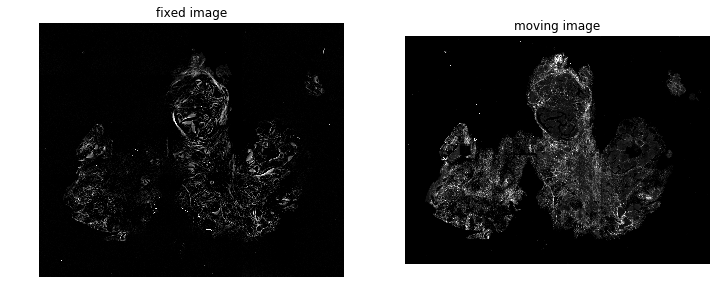

In [7]:
display_images(fixed, moving)

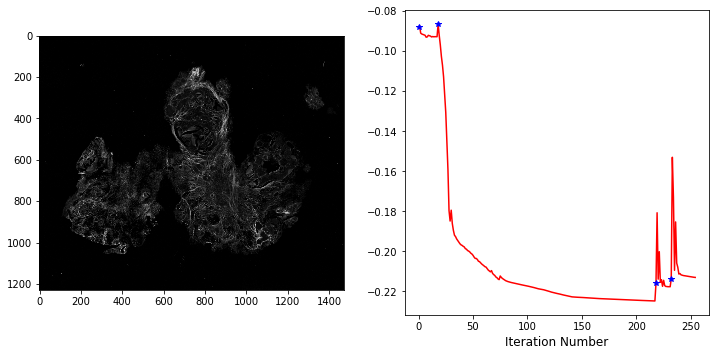

Final metric value: -0.21304440793814278
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 23 iterations. Gradient magnitude (9.13982e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (0000022A9876B9B0)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 9657739
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.0008 0.000456954 
     -0.00147489 0.995622 
   Offset: [-63.1734, -305.423]
   Center: [0, 0]
   Translation: [-63.1734, -305.423]
   Inverse: 
     0.999195 -0.000458594 
     0.00148018 1.0044 
   Singular: 0



In [8]:
(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)

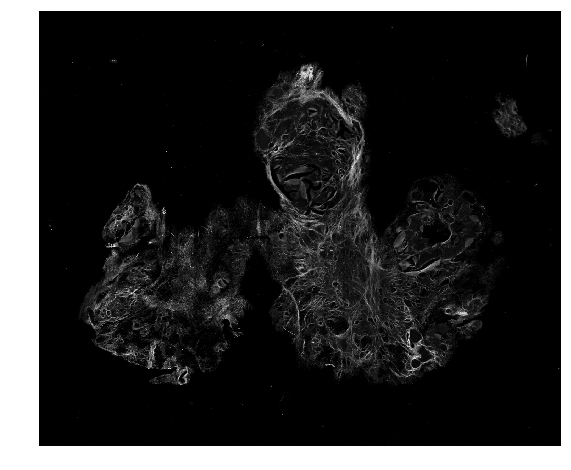

In [9]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [10]:
# Get the MMP image for a mask and apply it to the SHG.
mask = sitk.ReadImage(OutDir + sample + '_RegularStepAffineReg.tif', sitk.sitkFloat32) > 0
mask.SetSpacing([5.416, 5.416])
masked_SHG = sitk.Mask(registered,mask)
#myshow(masked_SHG)

In [11]:
sitk.WriteImage(masked_SHG,os.path.join(OutDir, sample +'_SHG_RegularStepAffineReg.tif'))

# WP4

WP4

In [12]:
sample = 'WP4'

fixed = sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32)
fixed.SetSpacing([5.416,5.416])

moving = resizeImage(sitk.ReadImage(SHGDir + sample + '_SHG.tif', sitk.sitkFloat32), 0.619, 5.75)

print(moving.GetSpacing())

(5.571, 5.571)


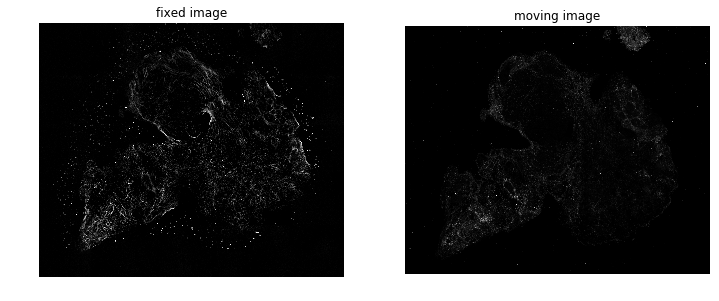

In [13]:
display_images(fixed, moving)

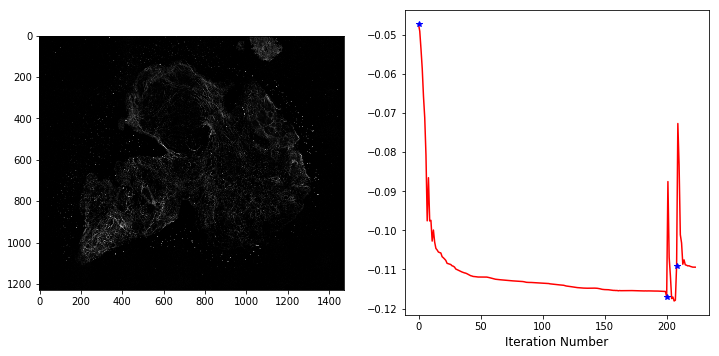

Final metric value: -0.103977154733068
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 0 iterations. Gradient magnitude (3.3625e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (0000022A9876A1F0)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 19309208
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00165 -0.008184 
     0.00699441 0.998889 
   Offset: [-145.214, -33.646]
   Center: [0, 0]
   Translation: [-145.214, -33.646]
   Inverse: 
     0.9983 0.00817917 
     -0.00699029 1.00106 
   Singular: 0



In [14]:
(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)

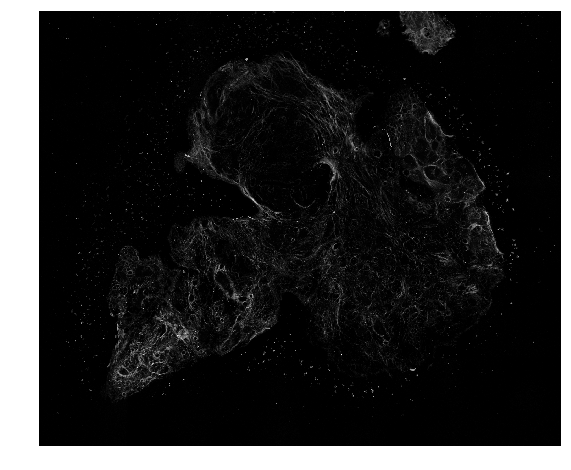

In [15]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [16]:
# Get the MMP image for a mask and apply it to the SHG.
mask = sitk.ReadImage(OutDir + sample + '_RegularStepAffineReg.tif', sitk.sitkFloat32) > 0
mask.SetSpacing([5.416, 5.416])
masked_SHG = sitk.Mask(registered,mask)
#myshow(masked_SHG)

In [17]:
sitk.WriteImage(masked_SHG,os.path.join(OutDir, sample +'_SHG_RegularStepAffineReg.tif'))

# WP5

In [18]:
sample = 'WP5'

fixed = sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32)
fixed.SetSpacing([5.416,5.416])

moving = resizeImage(sitk.ReadImage(SHGDir + sample + '_SHG.tif', sitk.sitkFloat32), 0.619, 5.75)

print(moving.GetSpacing())

(5.571, 5.571)


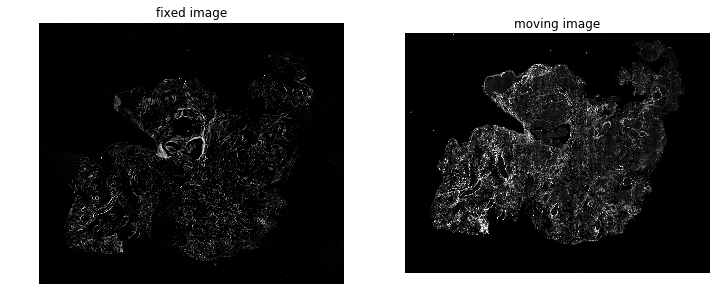

In [19]:
display_images(fixed, moving)

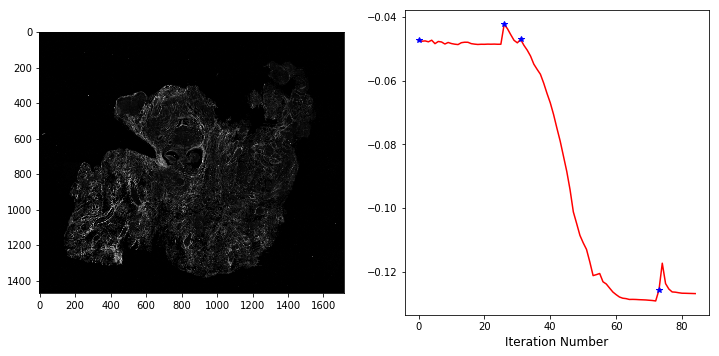

Final metric value: -0.12688821816914211
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 12 iterations. Gradient magnitude (8.59988e-05) is less than gradient magnitude tolerance (0.0001).
itk::simple::Transform
 AffineTransform (0000022A9CB13200)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 32736762
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.01259 -0.0121501 
     -0.0158297 0.954856 
   Offset: [98.778, -546.223]
   Center: [0, 0]
   Translation: [98.778, -546.223]
   Inverse: 
     0.987766 0.0125689 
     0.0163753 1.04749 
   Singular: 0



In [20]:
(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)

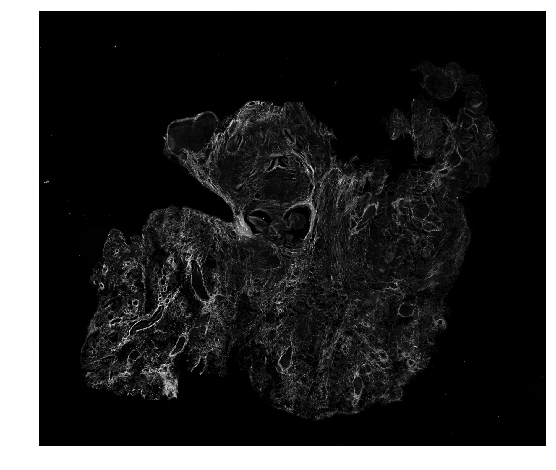

In [21]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [22]:
# Get the MMP image for a mask and apply it to the SHG.
mask = sitk.ReadImage(OutDir + sample + '_RegularStepAffineReg.tif', sitk.sitkFloat32) > 0
mask.SetSpacing([5.416, 5.416])
masked_SHG = sitk.Mask(registered,mask)
#myshow(masked_SHG)

In [23]:
sitk.WriteImage(masked_SHG,os.path.join(OutDir, sample +'_SHG_RegularStepAffineReg.tif'))

# WP9

In [24]:
sample = 'WP9'

fixed = sitk.ReadImage(PolDir + sample + '.tif', sitk.sitkFloat32)
fixed.SetSpacing([5.416,5.416])

moving = resizeImage(sitk.ReadImage(SHGDir + sample + '_SHG.tif', sitk.sitkFloat32), 0.619, 5.75)

print(moving.GetSpacing())

(5.571, 5.571)


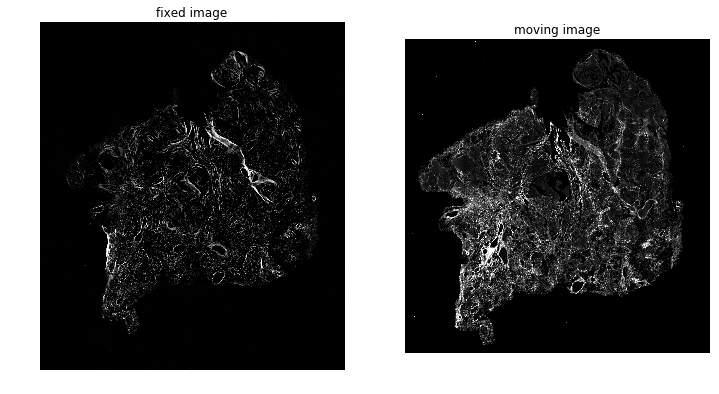

In [25]:
display_images(fixed, moving)

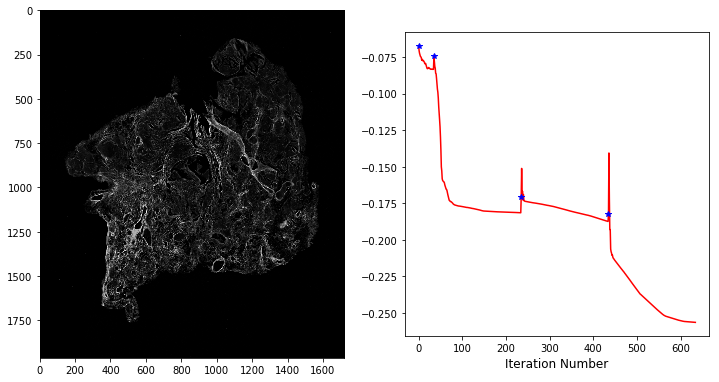

Final metric value: -0.25659524048361537
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
itk::simple::Transform
 AffineTransform (0000022A9CB12D00)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 3
   Modified Time: 50789586
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.997039 -0.0103974 
     0.00929035 0.997024 
   Offset: [-321.488, -603.485]
   Center: [0, 0]
   Translation: [-321.488, -603.485]
   Inverse: 
     1.00287 0.0104584 
     -0.00934484 1.00289 
   Singular: 0



In [26]:
(transform, metric, stop) = affine_registration(fixed, moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
print(transform)

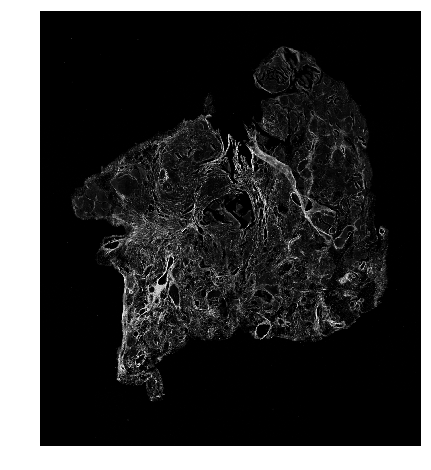

In [27]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images_with_alpha(0.7,fixed, registered)


In [28]:
# Get the MMP image for a mask and apply it to the SHG.
mask = sitk.ReadImage(OutDir + sample + '_RegularStepAffineReg.tif', sitk.sitkFloat32) > 0
mask.SetSpacing([5.416, 5.416])
masked_SHG = sitk.Mask(registered,mask)
#myshow(masked_SHG)

In [29]:
sitk.WriteImage(masked_SHG,os.path.join(OutDir, sample +'_SHG_RegularStepAffineReg.tif'))